In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report
import numpy as np

2025-06-12 02:14:34.953150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749690874.966510   91027 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749690874.970667   91027 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749690874.980640   91027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749690874.980654   91027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749690874.980656   91027 computation_placer.cc:177] computation placer alr

In [2]:
tf.__version__

'2.19.0'

# MODELO S

## 1 - Data Preprocessing

Caminhos dos sets

In [3]:
train_dir = 'dataset_balanceado_final/train'
validation_dir = 'dataset_balanceado_final/validation'
test_dir = 'dataset_balanceado_final/test'

Definir batch_size e image_size

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = 150
BATCH_SIZE = 32

Training set -  É o conjunto de dados usado para treinar a rede

In [5]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical' # categorical porque temos várias classes, senão seria binário (2 classes)
)

Found 4276 files belonging to 7 classes.


I0000 00:00:1749690877.404282   91027 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4804 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:03:00.0, compute capability: 7.5
I0000 00:00:1749690877.407857   91027 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4804 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5


Validation set - Usado para 'testar' o modelo durante o processo de procura da melhor combinação de hiperparâmetros.

In [6]:
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


Test set - Usado para testar o modelo depois do processo de treino

In [7]:
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


#### Data Augmentation 

Gerar mais dados de treino a partir de amostras de treino existentes, aumentando as amostras através de uma série de transformações aleatórias que produzem imagens com aspeto credível.

In [8]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"), # Efeito "espelho" a partir do eixo horizontal
                                      layers.RandomFlip("vertical"),# Aplica inversão vertical nas imagens.
                                      layers.RandomTranslation(0.1, 0.2), 
                                      layers.RandomRotation(0.4),])

### Métricas para avaliar os modelos

In [9]:
# Utiliza uma função(do sckicit-learn) para avaliar o desempenho do modelo, indicando Métricas como: 
    # f1-score do modelo
    # accuracy do modelo
    # accuracy por classe 

from sklearn.metrics import classification_report
import numpy as np

def print_classification_metrics(model, dataset, phase_name):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    print(f"\n {phase_name}")
    print(classification_report(y_true, y_pred, digits=4))


## 2 - Construir a CNN (convolucional Neural Network) 

In [10]:
# Define a camada de entrada do modelo com o formato das imagens (altura, largura, 3 canais RGB).
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) 

In [11]:
#Aplica as transformações aleatórias às imagens (definidas no inicio do notebook) para aumentar a diversidade do dataset de treino e evitar overfitting.
x = data_augmentation(inputs) 

In [12]:
# Normaliza os valores dos pixels das imagens de entrada para o intervalo [0, 1].
x = layers.Rescaling(1./255)(x) 

### Passo 1 : Camada Convolucional

In [13]:
# Primeira camada convolucional com 64 filtros 3x3 e ativação ReLU
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x) 
# adicionado o padding="same" para garantir que o output da camada convolucional tem a mesma dimensão espacial (altura e largura) que o input, após a operação de convolução.

### Passo 2 : Camada de Pooling

In [14]:
# Primeira camada de pooling máximo (2x2) para reduzir a dimensionalidade.
x = layers.MaxPooling2D(pool_size=2)(x)

### Passo 3 : Adicionar mais camadas 

In [15]:
# Segunda camada convolucional com 128 filtros 3x3 e ativação ReLU.
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
# Segunda camada de pooling máximo (2x2).
x = layers.MaxPooling2D(pool_size=2)(x)

In [16]:
# Terceira camada convolucional com 128 filtros 3x3 e ativação ReLU.
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
# Terceira camada de pooling máximo (2x2).
x = layers.MaxPooling2D(pool_size=2)(x)

### Passo 4 : Flattening 

In [17]:
# Achata o output das camadas convolucionais para um vetor 1D.
x = layers.Flatten()(x)

BATCH NORMALIZATION  (Facultativo)

In [18]:
# tirar comentario desta linha abaixo se queremos usar batch normalization
# porem foi testado varias vezes e em diferentes camadas da rede, mas não melhorou o desempenho do modelo (e o optuna tambem sugeriu nao utilizar)
#x = layers.BatchNormalization( axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,beta_initializer="zeros",    moving_mean_initializer="zeros", moving_variance_initializer="ones")(x)

#### Dropout (facultativo) - funçao de regularização

In [19]:
# Aplica Dropout (50%) para desativar aleatoriamente neurónios, prevenindo o overfitting.
# Neste caso, para este modelo em especifico, atingiu a pior acc sem dropout
#x = layers.Dropout(0.5)(x)

### Passo 5 : Full Connection

In [20]:
# Definir funçao de Regularização L2 (opcional)
reg = regularizers.l2(0.01)  # Executar para ativar

# Camada densa (totalmente conectada) com 128 neurónios, ativação ReLU e funçao de regularizaçao L2
x = layers.Dense(128, activation="relu", kernel_regularizer=reg)(x)

### Passo 6 : Output Layer

In [21]:
# Camada de saída densa com 7 neurónios e ativação Softmax (para classificação categórica).
outputs = layers.Dense(7, activation="softmax")(x) 

In [22]:
# Cria o modelo Keras usando as camadas de entrada e saída definidas.
model = keras.Model(inputs=inputs, outputs=outputs)

## 3 - Treinar a rede CNN 

#### Funções de otimização disponíveis: Adam, RMSprop e SGD

#### Funções de loss disponíveis: categorical_crossentropy    ,    KLDivergence e MSE 

In [23]:
# Configura o otimizador: SGD
# Define a função de loss: MSE
# Indica que a 'accuracy' (precisão) será a métrica durante o treino.
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='mse',
    metrics=['accuracy'])

In [24]:
#model.compile(
    #optimizer='SGD', 
    #loss='mse',
    #metrics=['accuracy'])

In [25]:
#model.compile(
    #optimizer=tf.keras.optimizers.RMSprop(),
    #loss=tf.keras.losses.KLDivergence(),
    #metrics=['accuracy'])

### Treinar o modelo

In [26]:
history = model.fit(
    train_dataset, #Inicia o treino do modelo usando o conjunto de dados de treino.
    epochs=25,     # O modelo será treinado por 25 épocas (passagens completas pelo conjunto de treino).
    validation_data=validation_dataset) # Usa o conjunto de dados de validação para monitorizar o desempenho do modelo em dados não vistos durante o treino.

Epoch 1/25


I0000 00:00:1749690880.720096   98298 cuda_dnn.cc:529] Loaded cuDNN version 90300


134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.1599 - loss: 2.6415 - val_accuracy: 0.1535 - val_loss: 2.5420
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1738 - loss: 2.5099 - val_accuracy: 0.1514 - val_loss: 2.4157
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1718 - loss: 2.3853 - val_accuracy: 0.1444 - val_loss: 2.2959
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1667 - loss: 2.2672 - val_accuracy: 0.1577 - val_loss: 2.1824
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1798 - loss: 2.1552 - val_accuracy: 0.1662 - val_loss: 2.0749
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1946 - loss: 2.0490 - val_accuracy: 0.1768 - val_loss: 1.9729
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1957 - loss: 1.9484 - val_accuracy: 0.1993 - val_loss: 1.8763
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.2141 - loss: 1.8531 - val_accurac

## 4 - Testar o modelo

In [27]:
print_classification_metrics(model, test_dataset, "Modelo 1 : CNN de raiz")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

2025-06-12 02:18:48.451744: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/eliana/escola/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eliana/escola/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eliana/escola/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

### Ver as Curvas de Loss e de Accuracy

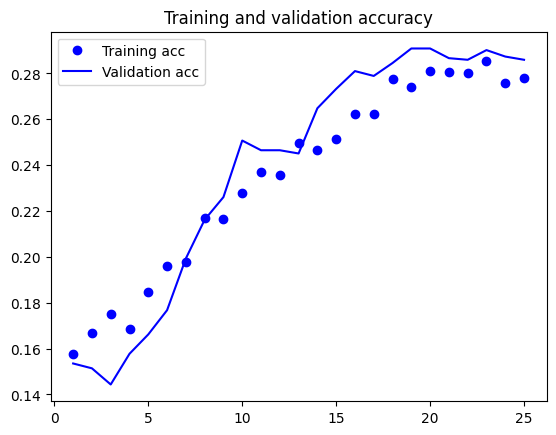

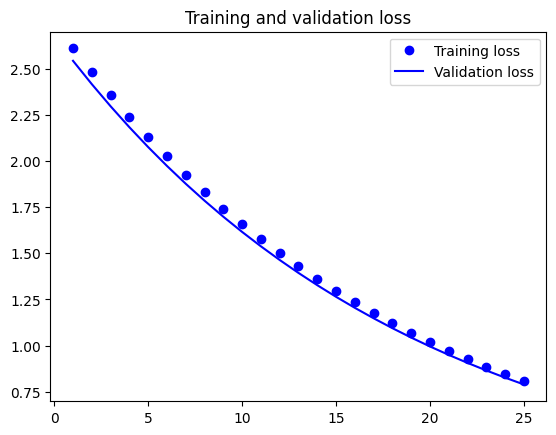

In [28]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

A acurácia de treino e validação aumentam de forma gradual ao longo das 25 épocas, atingindo cerca de 0.29, o que indica que o modelo está a aprender, mas ainda tem desempenho bastante limitado. Isso pode estar relacionado ao uso da MSE como função de perda, que não é ideal para classificação.

As perdas de treino e validação diminuem de forma consistente e estão muito próximas, o que indica que não há overfitting, mas sim que o modelo está a aprender de forma ineficiente para a tarefa proposta. A função de perda MSE pode estar a dificultar a convergência para uma solução que realmente separe bem as classes.

### Matriz de Confusão

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

2025-06-12 02:18:52.545861: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

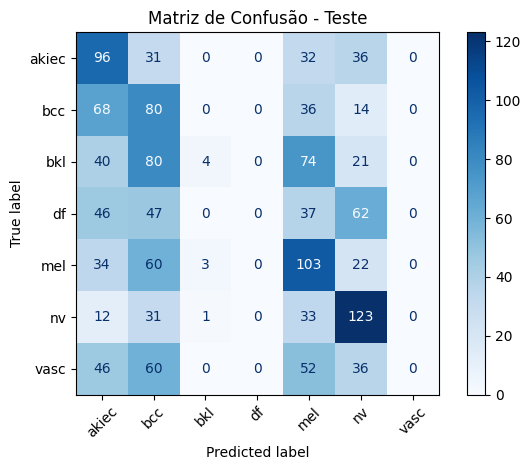

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obter predições no test_dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

class_names = test_dataset.class_names  

# Criar e mostrar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')
plt.title("Matriz de Confusão - Teste")
plt.tight_layout()
plt.show()

## Salvar o modelo 

In [29]:
model.save("modelS_2B3_com_data_aug_SGD_MSE_worst_acc.keras")